# Backtest Strategy

In [3]:
from datetime import datetime, timedelta
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

def save_data_to_df(response_json):
    data = []
    for position in response_json.get('LP_positions', []):
        burn_data = position.get('burn', {})
        info_data = position.get('info', {})
        mint_data = position.get('mint', {})
        swap_data = position.get('swap', {})

        data.append({
            'start': info_data.get('start'),
            'end': info_data.get('end'),
            'curr_price': burn_data.get('burn_price') / 1e18,
            'lower_price': info_data.get('lower_price'),
            'upper_price': info_data.get('upper_price'),
            'X_start': info_data.get('X_start'),
            'Y_start': info_data.get('Y_start'),
            'liquidity': mint_data.get('liquidity'),
            'X_left': mint_data.get('X_left')/1e8,
            'X_mint': mint_data.get('X_mint')/1e8,
            'Y_left': mint_data.get('Y_left')/1e18,
            'Y_mint': mint_data.get('Y_mint')/1e18,
            'X_fee': burn_data.get('X_fee')/1e8,
            'X_reserve': burn_data.get('X_reserve')/1e8,
            'Y_fee': burn_data.get('Y_fee')/1e18,
            'Y_reserve': burn_data.get('Y_reserve')/1e18,
            'APR': info_data.get('APR'),
            'Impermanent_loss': info_data.get('Impermanent_loss'),
            'PnL': info_data.get('PnL'),
            'Yield': info_data.get('Yield')
        })

    final_result = response_json.get('final_result', {})
    final_result_data = {
        'final_PnL': final_result.get('PnL'),
        'final_fee_value': final_result.get('fee_value')/1e18,
        'final_fee_yield': final_result.get('fee_yield'),
        'final_impermanent_loss': final_result.get('impermanent_loss'),
        'final_portfolio_value_end': final_result.get('portfolio_value_end')/1e18,
        'final_portfolio_value_start': final_result.get('portfolio_value_start')/1e18
    }

    data_df = pd.DataFrame(data)
    final_result_df = pd.DataFrame([final_result_data])

    return data_df, final_result_df

def save_data_to_csv(data_df):
    import os
    # Construct the filename
    filename = f"{agent}_{pool_id}_{start_date}_to_{end_date}.csv"

    # Define the directory where the file will be saved
    directory = "/Users/idrees/Code/ILP-Framework/model_outdir_csv/backtest"

    # Create the full file path
    file_path = os.path.join(directory, filename)

    # Save the DataFrame to CSV
    data_df.to_csv(file_path, index=False)

def plot_prices_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    plt.plot(data_df['start'], data_df['curr_price'], label='Current Price')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_action_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['lower_price'], label='Lower Price')
    plt.plot(data_df['start'], data_df['upper_price'], label='Upper Price')
    
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Price Ranges Over Time')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_apr_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['APR'])
    plt.xlabel('Date')
    plt.ylabel('APR')
    plt.title('APR Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_il_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Impermanent_loss'])
    plt.xlabel('Date')
    plt.ylabel('Impermanent Loss')
    plt.title('Impermanent Loss Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_pnl_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['PnL'])
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.title('PnL Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_yield_over_time(data_df):
    plt.figure(figsize=(10, 6))
    plt.plot(data_df['start'], data_df['Yield'])
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.title('Yield Over Time')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def price_to_raw_tick(price):
    return math.floor(math.log(price) / math.log(1.0001))

def price_to_valid_tick(price, tick_spacing=60):
    raw_tick = math.floor(math.log(price, 1.0001))
    remainder = raw_tick % tick_spacing
    if remainder != 0:
        # Round to the nearest valid tick, considering tick spacing.
        raw_tick += tick_spacing - remainder if remainder >= tick_spacing // 2 else -remainder
    return raw_tick

def datetime_to_unix_timestamp(date_str, format='%Y-%m-%d %H:%M:%S'):
    dt = datetime.strptime(date_str, format)
    return int(time.mktime(dt.timetuple()))

def get_inference_all_positions(start_date, end_date,pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent):
    current_date = datetime.strptime(start_date, '%d-%m-%y')
    end_date = datetime.strptime(end_date, '%d-%m-%y')

    all_positions = []

    while current_date <= end_date:
        curr_date_str = current_date.strftime('%Y-%m-%d')
        # Step 3: Predict new positions
        ddpg_action, ppo_action = get_inference(ddpg_agent_path, ppo_agent_path, pool_id, curr_date_str)
        
        # Step 4: Rebalance portfolio
        start_interval = current_date
        end_interval = current_date + timedelta(days=rebalancing_frequency)
        start_date_str = start_interval.strftime('%Y-%m-%d %H:%M:%S')
        end_date_str = end_interval.strftime('%Y-%m-%d %H:%M:%S')

        start_timestamp = datetime_to_unix_timestamp(start_date_str)
        end_timestamp = datetime_to_unix_timestamp(end_date_str)

        if agent == "ddpg":
            price_lower = ddpg_action['price_lower']
            price_upper = ddpg_action['price_upper']
            
        else:
            price_lower = ppo_action['price_lower']
            price_upper = ppo_action['price_upper']
            
        print(f'price_lower: {price_lower} & price_upper: {price_upper}')
        # Collect all positions in a list
        all_positions.append({
            "start": start_timestamp,
            "end": end_timestamp,
            "lower_tick": price_to_valid_tick(price_lower,1),
            "upper_tick": price_to_valid_tick(price_upper,1),
        })


        # Move to the next rebalancing date
        current_date += timedelta(days=rebalancing_frequency)

    return all_positions


def get_inference(ddpg_agent_path='model_storage/ddpg/ddpg_1', ppo_agent_path='model_storage/ppo/lstm_actor_critic_batch_norm', pool_id="0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", date_str='2024-05-05', api_key='igVj0yhN8gw9rlv'):
    url = "https://ilp.tempestfinance.xyz/api/v1/predict-action/"
    headers = {
        'Content-Type': 'application/json',
        'x-api-key': api_key
    }
    data = {
        "pool_id": pool_id,
        "ddpg_agent_path": ddpg_agent_path,
        "ppo_agent_path": ppo_agent_path,
        "date_str": date_str
    }
    # Make the POST request
    response = requests.post(url, json=data, headers=headers)
    
    # Check if the request was successful
    if response.status_code == 200:
        try:
            response_json = response.json()
            ddpg_action = response_json.get('ddpg_action', {})
            ppo_action = response_json.get('ppo_action', {})
            return ddpg_action, ppo_action
        except ValueError:
            print("Failed to parse JSON response.")
            return None, None
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")
        return None, None


def simulate_all_positions(X_reserve, Y_reserve, positions):
    print(positions)
    vector = {
        "datatype": "raw",
        "fee_tier":100,
        "pool": "0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa",
        "token0": X_reserve,
        "token1": Y_reserve,
        "range_type": "tick",
        "positions": positions
    }
    url = "https://voyager-simulation.tempestfinance.xyz/MVP"
    response = requests.post(url, json=vector)
    print(response.text)

    return response

start_date = '01-05-24'
end_date = '01-08-24'
ddpg_agent_path = 'model_storage/ddpg/ddpg_1'
ppo_agent_path = 'model_storage/ppo/lstm_actor_critic_batch_norm'
pool_id = "0x109830a1aaad605bbf02a9dfa7b0b92ec2fb7daa"
agent = "ppo"


X_reserve = 5e18
Y_reserve = 5e18
rebalancing_frequency = 1


all_positions = get_inference_all_positions(start_date, end_date, pool_id, ddpg_agent_path, ppo_agent_path, rebalancing_frequency, agent)
# Step 5: Send all positions to the simulator API in a single request
all_positions


price_lower: 0.17235361942278826 & price_upper: 2.274029228820267
price_lower: 0.23926195746139456 & price_upper: 2.2075831222938938
price_lower: 1.1259934421625784 & price_upper: 1.3209598442124442
price_lower: 0.8039255613655562 & price_upper: 1.643992614408787
price_lower: 0.24850938385635668 & price_upper: 2.198802345964515
price_lower: 0.46253213899039597 & price_upper: 1.9854412647410709
price_lower: 0.8758465348796722 & price_upper: 1.5722068065528088
price_lower: 1.0077851497281862 & price_upper: 1.4404744401092684
price_lower: 0.82914989586347 & price_upper: 1.6190957055603905
price_lower: 0.24975278791748812 & price_upper: 2.1987873953989747
price_lower: 0.16753881917220298 & price_upper: 2.2807988998787754
price_lower: 0.21760043272886653 & price_upper: 2.2309999785878727
price_lower: 0.9451291758255889 & price_upper: 1.5036087256967345
price_lower: 0.6444070848732535 & price_upper: 1.8041744930833608
price_lower: 1.2104002215649503 & price_upper: 1.2378348103463472
price_lo

[{'start': 1714503600,
  'end': 1714590000,
  'lower_tick': -17583,
  'upper_tick': 8215},
 {'start': 1714590000,
  'end': 1714676400,
  'lower_tick': -14303,
  'upper_tick': 7919},
 {'start': 1714676400,
  'end': 1714762800,
  'lower_tick': 1186,
  'upper_tick': 2783},
 {'start': 1714762800,
  'end': 1714849200,
  'lower_tick': -2183,
  'upper_tick': 4971},
 {'start': 1714849200,
  'end': 1714935600,
  'lower_tick': -13924,
  'upper_tick': 7879},
 {'start': 1714935600,
  'end': 1715022000,
  'lower_tick': -7711,
  'upper_tick': 6858},
 {'start': 1715022000,
  'end': 1715108400,
  'lower_tick': -1326,
  'upper_tick': 4525},
 {'start': 1715108400,
  'end': 1715194800,
  'lower_tick': 77,
  'upper_tick': 3649},
 {'start': 1715194800,
  'end': 1715281200,
  'lower_tick': -1874,
  'upper_tick': 4818},
 {'start': 1715281200,
  'end': 1715367600,
  'lower_tick': -13874,
  'upper_tick': 7879},
 {'start': 1715367600,
  'end': 1715454000,
  'lower_tick': -17867,
  'upper_tick': 8245},
 {'start'

In [4]:
response = simulate_all_positions(X_reserve, Y_reserve, all_positions)
print(response)
# Process the response to save data to a DataFrame
data_df, results_df = save_data_to_df(response.json())

save_data_to_csv(data_df)

[{'start': 1714503600, 'end': 1714590000, 'lower_tick': -17583, 'upper_tick': 8215}, {'start': 1714590000, 'end': 1714676400, 'lower_tick': -14303, 'upper_tick': 7919}, {'start': 1714676400, 'end': 1714762800, 'lower_tick': 1186, 'upper_tick': 2783}, {'start': 1714762800, 'end': 1714849200, 'lower_tick': -2183, 'upper_tick': 4971}, {'start': 1714849200, 'end': 1714935600, 'lower_tick': -13924, 'upper_tick': 7879}, {'start': 1714935600, 'end': 1715022000, 'lower_tick': -7711, 'upper_tick': 6858}, {'start': 1715022000, 'end': 1715108400, 'lower_tick': -1326, 'upper_tick': 4525}, {'start': 1715108400, 'end': 1715194800, 'lower_tick': 77, 'upper_tick': 3649}, {'start': 1715194800, 'end': 1715281200, 'lower_tick': -1874, 'upper_tick': 4818}, {'start': 1715281200, 'end': 1715367600, 'lower_tick': -13874, 'upper_tick': 7879}, {'start': 1715367600, 'end': 1715454000, 'lower_tick': -17867, 'upper_tick': 8245}, {'start': 1715454000, 'end': 1715540400, 'lower_tick': -15252, 'upper_tick': 8024}, {

In [5]:
results_df.head()

,final_PnL,final_fee_value,final_fee_yield,final_impermanent_loss,final_portfolio_value_end,final_portfolio_value_start
0,8.700321,0.128899,1.187008,-7.513313,11.674993,10.859114


In [6]:

data_df.head(10)

,start,end,curr_price,lower_price,upper_price,X_start,Y_start,liquidity,X_left,X_mint,Y_left,Y_mint,X_fee,X_reserve,Y_fee,Y_reserve,APR,Impermanent_loss,PnL,Yield
0,1714503600,1714590000,1.164599e-18,0.172353,2.273815,5.000000e+18,5.000000e+18,11147316689041563648,-3.342610e-03,2.936625e+10,5.200690e-04,7.402438,2.992935e+05,2.937043e+10,3.448952e-05,7.401951,0.000067,1.822209e-07,1.822209e-07,0.000641
1,1714590000,1714676400,1.165040e-18,0.239254,2.207499,2.937073e+18,7.401986e+18,12223835899806001152,8.146304e+04,3.099818e+10,-4.706470e-13,7.212425,1.466127e+05,3.097671e+10,1.739336e-05,7.214925,0.001599,4.380365e-06,4.380365e-06,0.000319
2,1714676400,1714762800,1.165245e-18,1.125913,1.320864,3.097686e+18,7.214943e+18,128914125201267834880,1.497832e+07,7.265920e+10,8.932810e-13,2.356550,5.665568e+06,7.255417e+10,6.887135e-04,2.368789,0.003629,9.943354e-06,9.943354e-06,0.012461
3,1714762800,1714849200,1.165401e-18,0.803893,1.643906,7.255983e+18,2.369477e+18,30618311929691934720,-6.548590e-03,4.483868e+10,3.461191e-04,5.599002,1.241792e+04,4.481970e+10,1.668336e-06,5.601214,0.000499,1.367499e-06,1.367499e-06,0.000029
4,1714849200,1714935600,1.165659e-18,0.248496,2.198688,4.481971e+18,5.601216e+18,12375506040344516608,-3.617680e-03,3.117656e+10,3.146410e-04,7.190717,9.514301e+03,3.116389e+10,1.256915e-06,7.192194,0.000551,1.509223e-06,1.509223e-06,0.000022
5,1714935600,1715022000,1.165544e-18,0.462522,1.985291,3.116390e+18,7.192196e+18,16604135223028969472,3.021640e+05,3.594775e+10,-4.797060e-13,6.634470,1.095966e+05,3.595534e+10,1.276648e-05,6.633586,0.000147,4.027506e-07,4.027506e-07,0.000236
6,1715022000,1715108400,1.165712e-18,0.875821,1.572202,3.595545e+18,6.633599e+18,36841641936940670976,1.197784e+06,4.742923e+10,-2.498500e-13,5.296005,4.032569e+03,4.740467e+10,7.563883e-07,5.298868,0.000695,1.903528e-06,1.903528e-06,0.000011
7,1715108400,1715194800,1.165843e-18,1.007729,1.440344,4.740468e+18,5.298869e+18,58767561780361740288,1.033306e+06,5.463341e+10,2.898600e-14,4.456001,3.390890e+05,5.460289e+10,4.003209e-05,4.459560,0.000673,1.843714e-06,1.843714e-06,0.000735
8,1715194800,1715281200,1.165816e-18,0.829120,1.618947,5.460323e+18,4.459600e+18,32542174486740201472,-6.769570e-03,4.562983e+10,1.082591e-04,5.505544,1.999913e+05,4.563332e+10,2.342639e-05,5.505137,0.000016,4.347884e-08,4.347884e-08,0.000432
9,1715281200,1715367600,1.165966e-18,0.249741,2.198688,4.563352e+18,5.505160e+18,12392448868349925376,-3.621910e-03,3.119884e+10,3.325077e-04,7.187477,2.606559e+05,3.119145e+10,3.117969e-05,7.188340,0.000187,5.133628e-07,5.133628e-07,0.000569


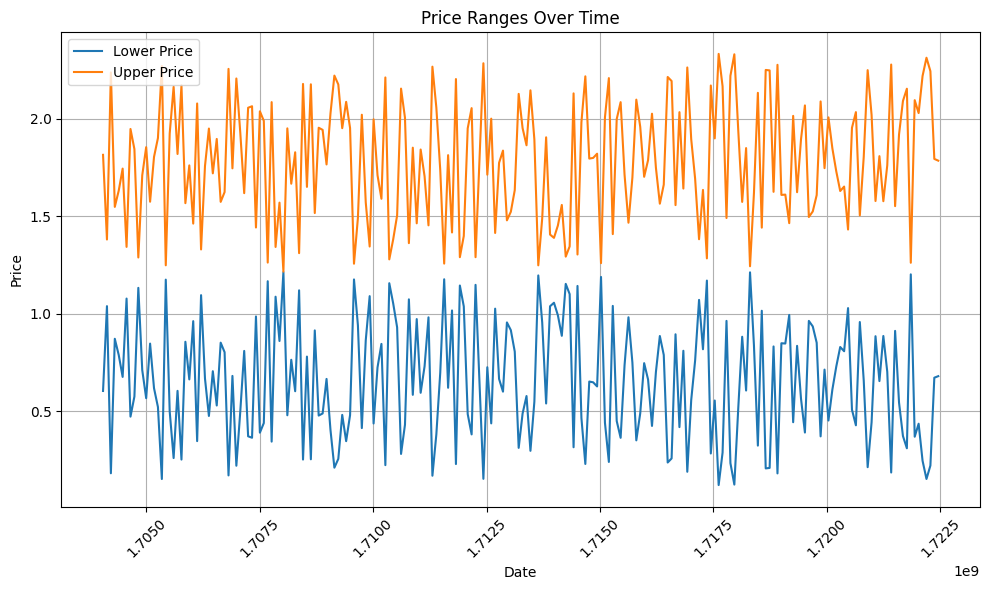

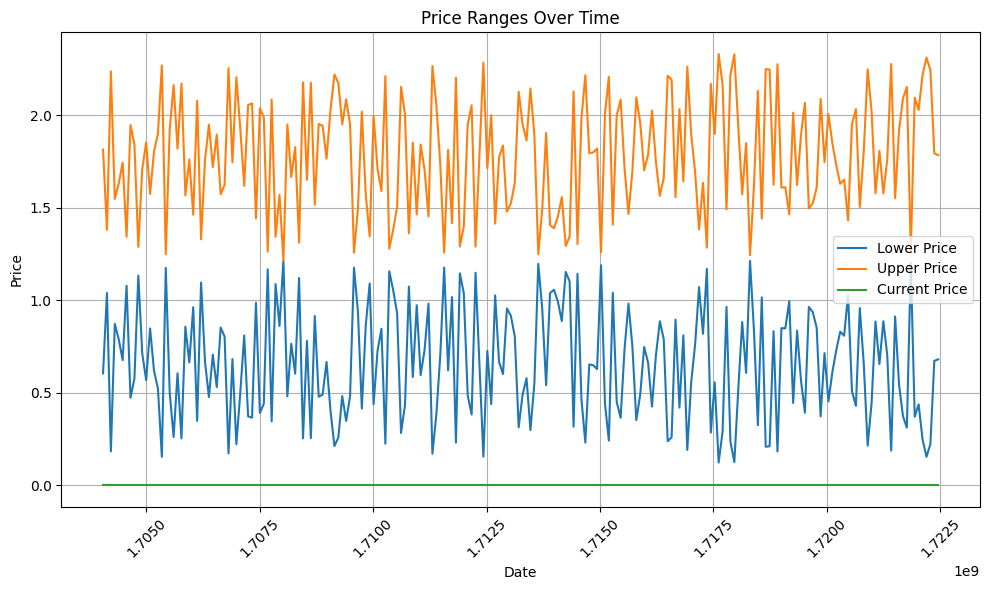

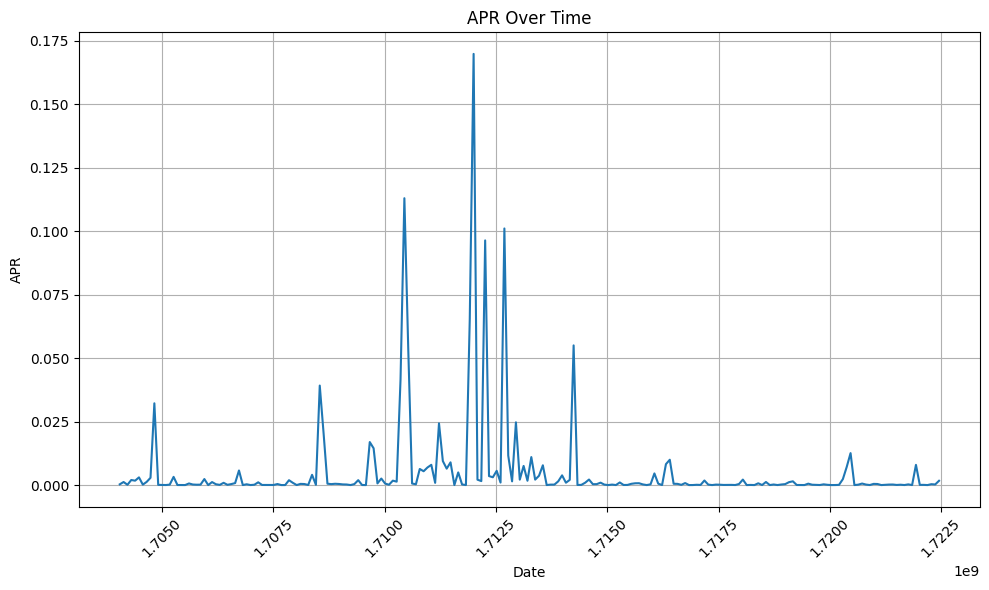

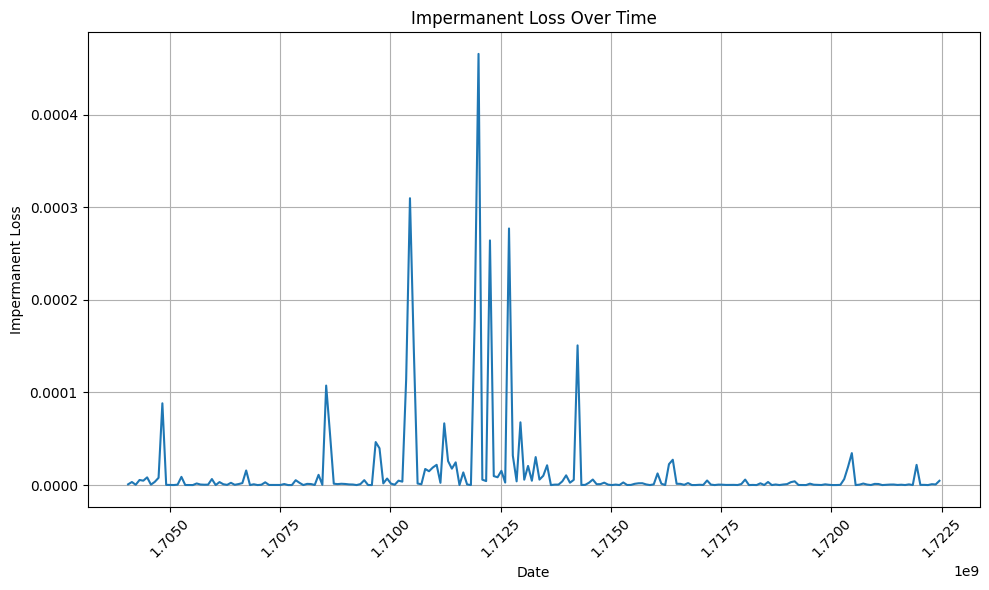

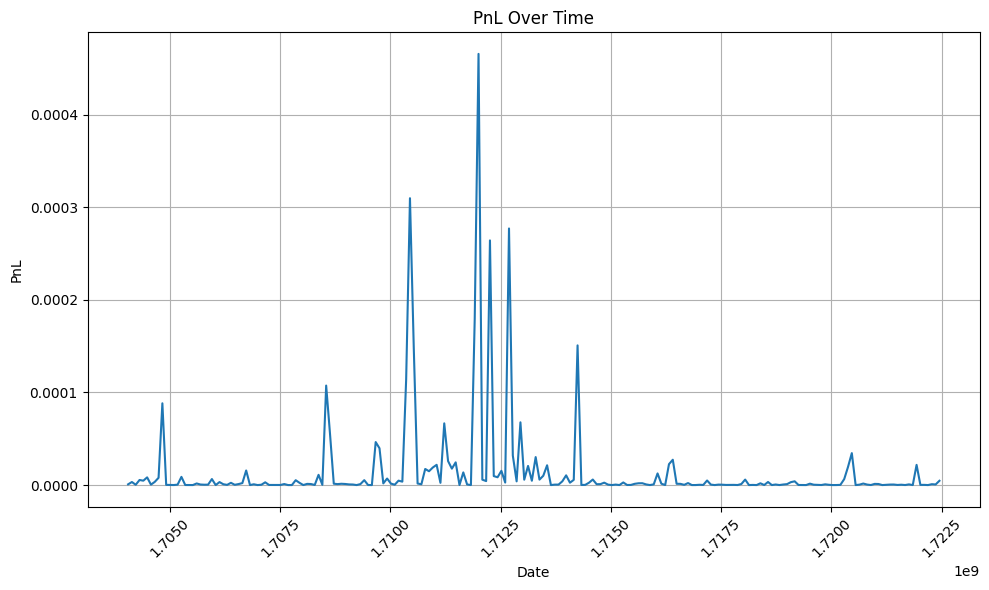

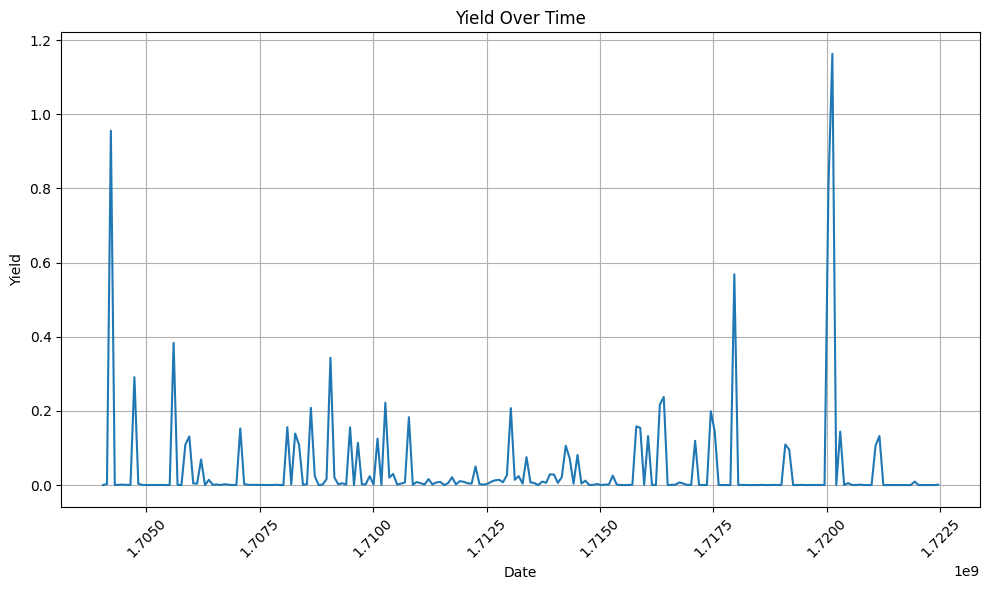

In [103]:

# Plotting the results
plot_action_over_time(data_df)
plot_prices_over_time(data_df)
plot_apr_over_time(data_df)
plot_il_over_time(data_df)
plot_pnl_over_time(data_df)
plot_yield_over_time(data_df)


In [112]:

get_inference()

({}, {})